In [1]:
import pandas as pd
import numpy as np
import pickle

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D

from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Dense, Flatten, Activation
import time
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 

In [2]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
DF_MRI = pd.read_excel(open('ja1c08181_si_002.xlsx', 'rb'),
              sheet_name='Data organized fluoro-monomer')  

In [4]:
DF_MRI

,TFEA,HexaFOEA,NonaFOEA,PEGA,HEA,MSEA,19F NMR Signal-to-Noise Ratioa,Weight % Fluorine,Molecular weight (Mn)b,Dispersity (Ɖ)b
0,0.00,0.00,0.10,0.90,0.00,0.00,20,0.036740,-,-
1,0.00,0.00,0.20,0.30,0.00,0.50,47,0.117168,7100,1.25
2,0.00,0.00,0.20,0.30,0.50,0.00,61,0.127174,8100,1.16
3,0.00,0.00,0.20,0.40,0.00,0.40,46,0.105659,7800,1.26
4,0.00,0.00,0.20,0.40,0.40,0.00,51,0.112017,-,-
...,...,...,...,...,...,...,...,...,...,...
413,0.65,0.00,0.00,0.15,0.15,0.05,X,0.187427,-,-
414,0.70,0.00,0.00,0.30,0.00,0.00,55,0.158419,-,-
415,0.75,0.00,0.00,0.00,0.05,0.20,X,0.277993,-,-
416,0.80,0.00,0.00,0.10,0.00,0.10,X,0.243231,-,-


In [5]:
TFEA = 'C(OC(=O)C(C[*])[*])C(F)(F)F'
HexaFOEA = 'O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)C(F)(F)F'
NonaFOEA = 'O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(F)(F)F'
PEGA = 'O(C(=O)C(C[*])[*])CCOC'
HEA = 'O(C(=O)C(C[*])[*])CCO[H]'
MSEA = 'O(C(=O)C(C[*])[*])CC[S](C)=O'

In [6]:
Flag = [i != 'X' for i in DF_MRI['19F NMR Signal-to-Noise Ratioa']]

In [7]:
DF_MRI[Flag]

,TFEA,HexaFOEA,NonaFOEA,PEGA,HEA,MSEA,19F NMR Signal-to-Noise Ratioa,Weight % Fluorine,Molecular weight (Mn)b,Dispersity (Ɖ)b
0,0.0,0.0,0.1,0.9,0.0,0.0,20,0.036740,-,-
1,0.0,0.0,0.2,0.3,0.0,0.5,47,0.117168,7100,1.25
2,0.0,0.0,0.2,0.3,0.5,0.0,61,0.127174,8100,1.16
3,0.0,0.0,0.2,0.4,0.0,0.4,46,0.105659,7800,1.26
4,0.0,0.0,0.2,0.4,0.4,0.0,51,0.112017,-,-
...,...,...,...,...,...,...,...,...,...,...
408,0.6,0.0,0.0,0.3,0.1,0.0,50,0.137867,4600,1.37
409,0.6,0.0,0.0,0.4,0.0,0.0,31,0.120230,-,-
410,0.6,0.0,0.0,0.4,0.0,0.0,47,0.120230,-,-
411,0.6,0.0,0.0,0.4,0.0,0.0,52,0.120230,-,-


In [8]:
MOL = pd.DataFrame(['C(OC(=O)C(C[*])[*])C(F)(F)F',
'O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)C(F)(F)F',
'O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(F)(F)F',
'O(C(=O)C(C[*])[*])CCOC',
'O(C(=O)C(C[*])[*])CCO[H]',
'O(C(=O)C(C[*])[*])CC[S](C)=O'])[0].apply(Chem.MolFromSmiles)

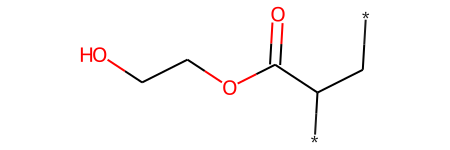

In [41]:
MOL[4]

In [9]:
MOL

0    <rdkit.Chem.rdchem.Mol object at 0x000001F5477...
1    <rdkit.Chem.rdchem.Mol object at 0x000001F5477...
2    <rdkit.Chem.rdchem.Mol object at 0x000001F5477...
3    <rdkit.Chem.rdchem.Mol object at 0x000001F5477...
4    <rdkit.Chem.rdchem.Mol object at 0x000001F5477...
5    <rdkit.Chem.rdchem.Mol object at 0x000001F5477...
Name: 0, dtype: object

In [10]:
Dataset_2 = DF_MRI[Flag].copy()

In [11]:
Dataset_2['Smiles'] = np.nan
for i in range(len(Dataset_2)):
    smi = 'C'
    if Dataset_2['TFEA'].iloc[i] > 0:
        smi = smi + '.C(OC(=O)C(C[*])[*])C(F)(F)F'
    if Dataset_2['HexaFOEA'].iloc[i] > 0:
        smi = smi + '.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)C(F)(F)F'
    if Dataset_2['NonaFOEA'].iloc[i] > 0:
        smi = smi + '.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(F)(F)F'
    if Dataset_2['PEGA'].iloc[i] > 0:
        smi = smi + '.O(C(=O)C(C[*])[*])CCOC'
    if Dataset_2['HEA'].iloc[i] > 0:
        smi = smi + '.O(C(=O)C(C[*])[*])CCO[H]'
    if Dataset_2['MSEA'].iloc[i] > 0:
        smi = smi + '.O(C(=O)C(C[*])[*])CC[S](C)=O'
    Dataset_2['Smiles'].iloc[i] = smi   

C:\Users\let20002\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [13]:
with open('Copolymer_Dataset_2.pickle', 'wb') as handle:
    pickle.dump(Dataset_2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
Dataset_2

,TFEA,HexaFOEA,NonaFOEA,PEGA,HEA,MSEA,19F NMR Signal-to-Noise Ratioa,Weight % Fluorine,Molecular weight (Mn)b,Dispersity (Ɖ)b,Smiles
0,0.0,0.0,0.1,0.9,0.0,0.0,20,0.036740,-,-,C.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(...
1,0.0,0.0,0.2,0.3,0.0,0.5,47,0.117168,7100,1.25,C.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(...
2,0.0,0.0,0.2,0.3,0.5,0.0,61,0.127174,8100,1.16,C.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(...
3,0.0,0.0,0.2,0.4,0.0,0.4,46,0.105659,7800,1.26,C.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(...
4,0.0,0.0,0.2,0.4,0.4,0.0,51,0.112017,-,-,C.O(C(=O)C(C[*])[*])CCOC(C(F)(F)F)(C(F)(F)F)C(...
...,...,...,...,...,...,...,...,...,...,...,...
408,0.6,0.0,0.0,0.3,0.1,0.0,50,0.137867,4600,1.37,C.C(OC(=O)C(C[*])[*])C(F)(F)F.O(C(=O)C(C[*])[*...
409,0.6,0.0,0.0,0.4,0.0,0.0,31,0.120230,-,-,C.C(OC(=O)C(C[*])[*])C(F)(F)F.O(C(=O)C(C[*])[*...
410,0.6,0.0,0.0,0.4,0.0,0.0,47,0.120230,-,-,C.C(OC(=O)C(C[*])[*])C(F)(F)F.O(C(=O)C(C[*])[*...
411,0.6,0.0,0.0,0.4,0.0,0.0,52,0.120230,-,-,C.C(OC(=O)C(C[*])[*])C(F)(F)F.O(C(=O)C(C[*])[*...


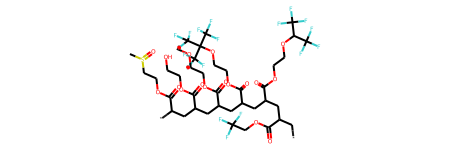

In [15]:
Chem.MolFromSmiles('C(OC(=O)C(C[*])CC(C(OCCOC(C(F)(F)F)C(F)(F)F)=O)CC(C(OCCOC(C(F)(F)F)(C(F)(F)F)C(F)(F)F)=O)CC(C(OCCOC)=O)CC(C(OCCO[H])=O)CC(C(OCC[S](C)=O)=O)[*])C(F)(F)F')

In [191]:
mol = Chem.MolFromSmiles('C(OC(=O)C(C[*])CC(C(OCCOC(C(F)(F)F)C(F)(F)F)=O)CC(C(OCCOC(C(F)(F)F)(C(F)(F)F)C(F)(F)F)=O)CC(C(OCCOC)=O)CC(C(OCCO[H])=O)CC(C(OCC[S](C)=O)=O)[*])C(F)(F)F')
d = rdMolDraw2D.MolDraw2DSVG(300, 300)
d.drawOptions().minFontSize = 32
d.DrawMolecule(mol)
d.FinishDrawing()
svg = d.GetDrawingText().replace('svg:', '')
with open('./SVG/MRI_all'+'.svg', 'w') as outfile:
    outfile.write(svg)

In [189]:
for i, mol in enumerate(MOL):

    d = rdMolDraw2D.MolDraw2DSVG(300, 300)
    d.drawOptions().minFontSize = 46
    d.DrawMolecule(mol)
    d.FinishDrawing()
    svg = d.GetDrawingText().replace('svg:', '')
    with open('./SVG/MRI_'+str(i)+'.svg', 'w') as outfile:
        outfile.write(svg)

In [15]:
fp_1 = MOL.apply(lambda m: AllChem.GetMorganFingerprint(m, radius=3))
fp_1_n = fp_1.apply(lambda m: m.GetNonzeroElements())

In [16]:
# using substructures in dataset-1 to construct a dictionary
HashCode = []
for i in fp_1_n:
    for j in i.keys():
        HashCode.append(j)

unique_set = set(HashCode)
unique_list = list(unique_set)

Corr_df = pd.DataFrame(unique_list).reset_index()

In [17]:
#construct dataset-1 input
MY_finger = []
for polymer in fp_1_n:
    my_finger = [0] * len(unique_list)
    for key in polymer.keys():
        index = Corr_df[Corr_df[0] == key]['index'].values[0]
        my_finger[index] = polymer[key]
    MY_finger.append(my_finger)

MY_finger_dataset = pd.DataFrame(MY_finger)  

In [18]:
MY_finger_dataset

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
1,2,0,1,1,2,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,2
2,1,0,0,0,2,0,0,1,3,1,...,1,1,1,1,0,0,0,0,0,0
3,1,0,0,0,2,0,1,0,0,0,...,0,0,1,1,0,0,1,0,1,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,1,0,0,0,0
5,1,1,0,0,1,0,1,0,0,0,...,0,0,1,1,1,0,0,0,0,0


In [19]:
# filter input into the most popular 124 substructures
Zero_Sum = (MY_finger_dataset == 0).astype(int).sum()
NumberOfZero = 6
print(len(Zero_Sum[Zero_Sum < NumberOfZero]))
X = MY_finger_dataset[Zero_Sum[Zero_Sum < NumberOfZero].index]

80


In [20]:
Mix_X = []
for i in range(len(DF_MRI[Flag])):
    Mix_X.append(X.iloc[0].values * DF_MRI[Flag]['TFEA'].iloc[i] + \
                 X.iloc[1].values * DF_MRI[Flag]['HexaFOEA'].iloc[i] + \
                 X.iloc[2].values * DF_MRI[Flag]['NonaFOEA'].iloc[i] + \
                 X.iloc[3].values * DF_MRI[Flag]['PEGA'].iloc[i] + \
                 X.iloc[4].values * DF_MRI[Flag]['HEA'].iloc[i] + \
                 X.iloc[5].values * DF_MRI[Flag]['MSEA'].iloc[i])
Mix_X = np.array(Mix_X)

### CNN

In [26]:
Mix_X_100Block = []
for i in range(len(DF_MRI[Flag])):
        random.seed(10)

        Random_position = []
        Random_position_all = []

        Rest = range(0, 100)
        for col in ['TFEA', 'HexaFOEA', 'NonaFOEA', 'PEGA', 'HEA', 'MSEA']:

            X_random_position = random.sample(Rest, int(DF_MRI[Flag][col].iloc[i] * 100))
            Random_position.append(X_random_position)
            for p in X_random_position:
                Random_position_all.append(p)
            Rest = []
            for x in range(0, 100):
                if x not in Random_position_all:
                    Rest.append(x)
        
        Sequency_X = [0 for a in range(100)]
        for j in range(100):
            if j in Random_position[0]:
                Sequency_X[j] = list(X.iloc[0].values)
            elif j in Random_position[1]:
                Sequency_X[j] = list(X.iloc[1].values)
            elif j in Random_position[2]:
                Sequency_X[j] = list(X.iloc[2].values)
            elif j in Random_position[3]:
                Sequency_X[j] = list(X.iloc[3].values)
            elif j in Random_position[4]:
                Sequency_X[j] = list(X.iloc[4].values)
            elif j in Random_position[5]:
                Sequency_X[j] = list(X.iloc[5].values)
                
        Mix_X_100Block.append(Sequency_X)   

Mix_X_100Block = np.array(Mix_X_100Block)

In [27]:
Mix_X_100Block.shape

(271, 100, 80)

In [28]:
Mix_X_100Block

array([[[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       [[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       [[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       ...,

       [[1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0]],

       [[1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        ...,
        [1, 0, 0, ..., 

In [29]:
Mix_X_100Block = Mix_X_100Block.reshape((271, 100, 80, 1))
Mix_X_100Block.shape

(271, 100, 80, 1)

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Mix_X_100Block, DF_MRI[Flag]['19F NMR Signal-to-Noise Ratioa'].astype(np.float64), test_size=0.2, random_state=42)

model = Sequential()
model.add(Conv2D(8, (10, 10), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(8, (4, 4), activation='relu'))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

#model.add(Conv2D(8, (4, 4), activation='relu'))
#model.add(Conv2D(8, (4, 4), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(10, activation='softmax'))

model.add(Flatten())
#model.add(Dense(4, activation='relu'))
model.add(Dense(1))
optimizer=keras.optimizers.Adam(lr=0.005)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
Model=model.fit(x=X_train,y=y_train,epochs=200,
                #callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
                batch_size=64,validation_split=0.2)

Epoch 1/200
3/3 [==============================] - 0s 97ms/step - loss: 61.2661 - val_loss: 14.9828
Epoch 2/200
3/3 [==============================] - 0s 31ms/step - loss: 35.8035 - val_loss: 17.7372
Epoch 3/200
3/3 [==============================] - 0s 14ms/step - loss: 32.2700 - val_loss: 33.3400
Epoch 4/200
3/3 [==============================] - 0s 15ms/step - loss: 34.7768 - val_loss: 13.9460
Epoch 5/200
3/3 [==============================] - 0s 15ms/step - loss: 21.6126 - val_loss: 16.6625
Epoch 6/200
3/3 [==============================] - 0s 15ms/step - loss: 15.6609 - val_loss: 16.4737
Epoch 7/200
3/3 [==============================] - 0s 11ms/step - loss: 18.7074 - val_loss: 13.8473
Epoch 8/200
3/3 [==============================] - 0s 13ms/step - loss: 15.4144 - val_loss: 15.2991
Epoch 9/200
3/3 [==============================] - 0s 14ms/step - loss: 13.1538 - val_loss: 13.0794
Epoch 10/200
3/3 [==============================] - 0s 13ms/step - loss: 13.8789 - val_loss: 12.9722

3/3 [==============================] - 0s 7ms/step - loss: 4.9256 - val_loss: 7.1083
Epoch 166/200
3/3 [==============================] - 0s 9ms/step - loss: 4.2637 - val_loss: 6.0306
Epoch 167/200
3/3 [==============================] - 0s 10ms/step - loss: 4.7053 - val_loss: 9.5254
Epoch 168/200
3/3 [==============================] - 0s 13ms/step - loss: 5.0527 - val_loss: 8.0865
Epoch 169/200
3/3 [==============================] - 0s 13ms/step - loss: 4.0803 - val_loss: 6.0941
Epoch 170/200
3/3 [==============================] - 0s 9ms/step - loss: 4.5557 - val_loss: 8.8021
Epoch 171/200
3/3 [==============================] - 0s 9ms/step - loss: 4.7254 - val_loss: 7.0787
Epoch 172/200
3/3 [==============================] - 0s 16ms/step - loss: 3.9593 - val_loss: 6.2434
Epoch 173/200
3/3 [==============================] - 0s 13ms/step - loss: 4.1740 - val_loss: 8.9116
Epoch 174/200
3/3 [==============================] - 0s 13ms/step - loss: 4.3706 - val_loss: 7.0774
Epoch 175/200
3/3 

In [33]:
filepath = 'MRI_CNN.model'
save_model(model, filepath, save_format='h5')

In [34]:
model = load_model('MRI_CNN.model')

In [35]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("Train set R^2: %.2f" % r2_score(y_train, y_pred_train))
print("Train MAE score: %.2f" % mean_absolute_error(y_train, y_pred_train))
print("Train RMSE score: %.2f" % np.sqrt(mean_squared_error(y_train, y_pred_train)))

print("Test set R^2: %.2f" % r2_score(y_test, y_pred_test))
print("Test MAE score: %.2f" % mean_absolute_error(y_test, y_pred_test))
print("Test RMSE score: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))

Train set R^2: 0.91
Train MAE score: 3.73
Train RMSE score: 6.76
Test set R^2: 0.77
Test MAE score: 8.21
Test RMSE score: 11.33


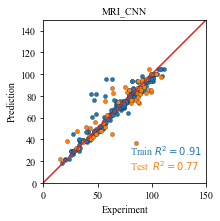

In [36]:
plt.figure(figsize=(3,3))

ax=plt.subplot(1, 1, 1)
plt.scatter(y_train, y_pred_train, c='#1f77b4', marker='o', s = 18, edgecolors='k', linewidths = 0.2)
plt.scatter(y_test, y_pred_test, c='#ff7f0e', marker='o', s = 18, edgecolors='k', linewidths = 0.2) 

plt.xlabel("Experiment",fontname="Times New Roman", fontsize=10)
plt.ylabel("Prediction",fontname="Times New Roman", fontsize=10)
x0, x1 = min(y_train), max(y_train)
length = 750
x_start, x_end = -200, 550
plt.xlim([-0, 150])
plt.ylim([-0, 150])
# ax.set_xticks([-200,-100,0,100,200,300,400,500])
# ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.yticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), '#d62728')
plt.text(80, 25, "Train $R^2={:.2f}$".format(round(r2_score(y_train, y_pred_train),2)),{'color':'#1f77b4'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.text(80, 12, "Test  $R^2 ={:.2f}$".format(r2_score(y_test, y_pred_test)),{'color':'#ff7f0e'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
#plt.text(80, 500, "Dataset_1")
plt.title('MRI_CNN',fontname="Times New Roman", fontsize=10)
plt.savefig("Polyinfo_MRI_CNN.png", dpi=1200, bbox_inches='tight') 

### Data Fusion

In [37]:
Mix_X = []
for i in range(len(DF_MRI[Flag])):
    Mix_X.append(X.iloc[0].values * DF_MRI[Flag]['TFEA'].iloc[i] + \
                 X.iloc[1].values * DF_MRI[Flag]['HexaFOEA'].iloc[i] + \
                 X.iloc[2].values * DF_MRI[Flag]['NonaFOEA'].iloc[i] + \
                 X.iloc[3].values * DF_MRI[Flag]['PEGA'].iloc[i] + \
                 X.iloc[4].values * DF_MRI[Flag]['HEA'].iloc[i] + \
                 X.iloc[5].values * DF_MRI[Flag]['MSEA'].iloc[i])
Mix_X = np.array(Mix_X)

In [38]:
Mix_X.shape

(271, 80)

In [39]:
Mix_X_100Block = []
for i in range(len(DF_MRI[Flag])):
        random.seed(10)

        Random_position = []
        Random_position_all = []

        Rest = range(0, 100)
        for col in ['TFEA', 'HexaFOEA', 'NonaFOEA', 'PEGA', 'HEA', 'MSEA']:

            X_random_position = random.sample(Rest, int(DF_MRI[Flag][col].iloc[i] * 100))
            Random_position.append(X_random_position)
            for p in X_random_position:
                Random_position_all.append(p)
            Rest = []
            for x in range(0, 100):
                if x not in Random_position_all:
                    Rest.append(x)
        
        Sequency_X = [0 for a in range(100)]
        for j in range(100):
            if j in Random_position[0]:
                Sequency_X[j] = 0
            elif j in Random_position[1]:
                Sequency_X[j] = 1
            elif j in Random_position[2]:
                Sequency_X[j] = 2
            elif j in Random_position[3]:
                Sequency_X[j] = 3
            elif j in Random_position[4]:
                Sequency_X[j] = 4
            elif j in Random_position[5]:
                Sequency_X[j] = 5
                
        Mix_X_100Block.append(Sequency_X)   

Mix_X_100Block = np.array(Mix_X_100Block)

In [40]:
Mix_X_100Block.shape

(271, 100)

In [41]:
Mix_X_100Block = Mix_X_100Block.reshape((271, 100, 1))
Mix_X_100Block.shape

(271, 100, 1)

In [42]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, LSTM, Embedding, Bidirectional, TimeDistributed, Reshape
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import mean_absolute_error, r2_score


def getRNNmodel(LSTMunits):#, out_dim, input_dim):

    RNNmodel = Sequential()
    #RNNmodel.add(Embedding(input_dim, out_dim, input_length=input_len))
    RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True), input_shape=(100,1)))
    #RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True)))
    RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True)))
    RNNmodel.add(TimeDistributed(Dense(int(LSTMunits/2), activation="relu")))
    RNNmodel.add(Reshape((int(LSTMunits/2*100),)))
    RNNmodel.add(Dense(1))

    return RNNmodel


In [43]:
#https://datascience.stackexchange.com/questions/26103/merging-two-different-models-in-keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model
from keras.layers.merge import Concatenate
from numpy.random import seed
import tensorflow

In [44]:
LSTMunits = 20

In [45]:
# define two sets of inputs
inputA = Input(shape=(100,1))
inputB = Input(shape=(80))
# the first branch operates on the first input

RNNmodel = Sequential()
#RNNmodel.add(Embedding(input_dim, out_dim, input_length=input_len))
RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True), input_shape=(100,1)))
#RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True)))
RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True)))
RNNmodel.add(TimeDistributed(Dense(int(LSTMunits/2), activation="relu")))
RNNmodel.add(Reshape((int(LSTMunits/2*100),)))

# the second branch opreates on the second input
y = Dense(8, activation="relu")(inputB)
y = Dense(8, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = Concatenate()([RNNmodel.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(8, activation="relu")(combined)
# z = Dense(8, activation="relu")(z)
z = Dense(1, activation="linear")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[RNNmodel.input, y.input], outputs=z)

In [46]:
# seed(211)
# tensorflow.random.set_seed(211*3+335)

xtrain_B, xtest_B, ytrain_B, ytest_B=train_test_split(Mix_X, DF_MRI[Flag]['19F NMR Signal-to-Noise Ratioa'].astype(np.float64), test_size=0.20, random_state=200)
xtrain_A, xtest_A, ytrain_A, ytest_A=train_test_split(Mix_X_100Block, DF_MRI[Flag]['19F NMR Signal-to-Noise Ratioa'].astype(np.float64), test_size=0.20, random_state=200)

#history = model.fit(xtrain, [ytrain, ytrain, ytrain], epochs=200, batch_size=32, validation_data = ((xtest), [ytest, ytest, ytest]), verbose=2)

model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss="mean_squared_error",
              metrics=["mean_squared_error"])

model.fit(
    x=[xtrain_A, xtrain_B], y=ytrain_B,
    validation_data=([xtest_A, xtest_B], ytest_B),
    epochs=300, batch_size=32, verbose=2) #epochs=100, batch_size=128, verbose=2)
# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = model.predict([xtest_A, xtest_B])

Epoch 1/300
7/7 - 1s - loss: 5212.6665 - mean_squared_error: 5212.6665 - val_loss: 5782.0825 - val_mean_squared_error: 5782.0825
Epoch 2/300
7/7 - 0s - loss: 5067.5605 - mean_squared_error: 5067.5605 - val_loss: 5491.6641 - val_mean_squared_error: 5491.6641
Epoch 3/300
7/7 - 0s - loss: 4588.8521 - mean_squared_error: 4588.8521 - val_loss: 4625.8413 - val_mean_squared_error: 4625.8408
Epoch 4/300
7/7 - 0s - loss: 3560.3528 - mean_squared_error: 3560.3528 - val_loss: 3216.6887 - val_mean_squared_error: 3216.6887
Epoch 5/300
7/7 - 0s - loss: 2141.4246 - mean_squared_error: 2141.4246 - val_loss: 1668.9349 - val_mean_squared_error: 1668.9349
Epoch 6/300
7/7 - 0s - loss: 944.5991 - mean_squared_error: 944.5991 - val_loss: 688.7554 - val_mean_squared_error: 688.7554
Epoch 7/300
7/7 - 0s - loss: 511.6656 - mean_squared_error: 511.6656 - val_loss: 660.0781 - val_mean_squared_error: 660.0781
Epoch 8/300
7/7 - 0s - loss: 633.0558 - mean_squared_error: 633.0558 - val_loss: 631.7342 - val_mean_squa

Epoch 66/300
7/7 - 0s - loss: 252.6399 - mean_squared_error: 252.6399 - val_loss: 273.9157 - val_mean_squared_error: 273.9157
Epoch 67/300
7/7 - 0s - loss: 252.1095 - mean_squared_error: 252.1095 - val_loss: 262.8105 - val_mean_squared_error: 262.8105
Epoch 68/300
7/7 - 0s - loss: 250.0717 - mean_squared_error: 250.0716 - val_loss: 264.7659 - val_mean_squared_error: 264.7659
Epoch 69/300
7/7 - 0s - loss: 245.0001 - mean_squared_error: 245.0001 - val_loss: 265.2361 - val_mean_squared_error: 265.2361
Epoch 70/300
7/7 - 0s - loss: 240.0700 - mean_squared_error: 240.0700 - val_loss: 242.1488 - val_mean_squared_error: 242.1488
Epoch 71/300
7/7 - 0s - loss: 233.8763 - mean_squared_error: 233.8763 - val_loss: 245.6126 - val_mean_squared_error: 245.6126
Epoch 72/300
7/7 - 0s - loss: 232.6420 - mean_squared_error: 232.6420 - val_loss: 249.3074 - val_mean_squared_error: 249.3074
Epoch 73/300
7/7 - 0s - loss: 229.0747 - mean_squared_error: 229.0747 - val_loss: 234.3808 - val_mean_squared_error: 2

Epoch 131/300
7/7 - 0s - loss: 164.3367 - mean_squared_error: 164.3367 - val_loss: 147.9104 - val_mean_squared_error: 147.9104
Epoch 132/300
7/7 - 0s - loss: 163.0797 - mean_squared_error: 163.0797 - val_loss: 142.0416 - val_mean_squared_error: 142.0416
Epoch 133/300
7/7 - 0s - loss: 160.8140 - mean_squared_error: 160.8140 - val_loss: 144.0696 - val_mean_squared_error: 144.0696
Epoch 134/300
7/7 - 0s - loss: 158.8383 - mean_squared_error: 158.8383 - val_loss: 141.9669 - val_mean_squared_error: 141.9669
Epoch 135/300
7/7 - 0s - loss: 158.4444 - mean_squared_error: 158.4444 - val_loss: 141.7402 - val_mean_squared_error: 141.7402
Epoch 136/300
7/7 - 0s - loss: 159.8076 - mean_squared_error: 159.8076 - val_loss: 140.8794 - val_mean_squared_error: 140.8794
Epoch 137/300
7/7 - 0s - loss: 158.2873 - mean_squared_error: 158.2873 - val_loss: 142.2295 - val_mean_squared_error: 142.2295
Epoch 138/300
7/7 - 0s - loss: 157.2545 - mean_squared_error: 157.2545 - val_loss: 141.8598 - val_mean_squared_

Epoch 196/300
7/7 - 0s - loss: 138.9390 - mean_squared_error: 138.9390 - val_loss: 113.7752 - val_mean_squared_error: 113.7752
Epoch 197/300
7/7 - 0s - loss: 136.9815 - mean_squared_error: 136.9815 - val_loss: 115.3176 - val_mean_squared_error: 115.3176
Epoch 198/300
7/7 - 0s - loss: 141.6818 - mean_squared_error: 141.6818 - val_loss: 112.5041 - val_mean_squared_error: 112.5041
Epoch 199/300
7/7 - 0s - loss: 138.7428 - mean_squared_error: 138.7428 - val_loss: 114.2977 - val_mean_squared_error: 114.2977
Epoch 200/300
7/7 - 0s - loss: 141.7183 - mean_squared_error: 141.7183 - val_loss: 114.9898 - val_mean_squared_error: 114.9898
Epoch 201/300
7/7 - 0s - loss: 153.4591 - mean_squared_error: 153.4591 - val_loss: 121.1083 - val_mean_squared_error: 121.1083
Epoch 202/300
7/7 - 0s - loss: 137.6707 - mean_squared_error: 137.6707 - val_loss: 117.9326 - val_mean_squared_error: 117.9326
Epoch 203/300
7/7 - 0s - loss: 134.3618 - mean_squared_error: 134.3618 - val_loss: 115.5249 - val_mean_squared_

Epoch 261/300
7/7 - 0s - loss: 107.1262 - mean_squared_error: 107.1262 - val_loss: 103.0726 - val_mean_squared_error: 103.0726
Epoch 262/300
7/7 - 0s - loss: 104.6565 - mean_squared_error: 104.6565 - val_loss: 116.2565 - val_mean_squared_error: 116.2565
Epoch 263/300
7/7 - 0s - loss: 101.5553 - mean_squared_error: 101.5553 - val_loss: 122.2747 - val_mean_squared_error: 122.2747
Epoch 264/300
7/7 - 0s - loss: 98.7160 - mean_squared_error: 98.7160 - val_loss: 111.5186 - val_mean_squared_error: 111.5186
Epoch 265/300
7/7 - 0s - loss: 95.9674 - mean_squared_error: 95.9674 - val_loss: 122.0534 - val_mean_squared_error: 122.0534
Epoch 266/300
7/7 - 0s - loss: 96.1769 - mean_squared_error: 96.1769 - val_loss: 111.0638 - val_mean_squared_error: 111.0638
Epoch 267/300
7/7 - 0s - loss: 93.7959 - mean_squared_error: 93.7959 - val_loss: 113.1277 - val_mean_squared_error: 113.1277
Epoch 268/300
7/7 - 0s - loss: 93.4479 - mean_squared_error: 93.4479 - val_loss: 115.3131 - val_mean_squared_error: 115

In [47]:
filepath = 'MRI_FusionModel.model'
save_model(model, filepath, save_format='h5')

In [48]:
model = load_model('MRI_FusionModel.model')

In [49]:
ytrain = ytrain_B
ytest = ytest_B

y_pred_train = model.predict([xtrain_A, xtrain_B])
print("Train set R^2: ", r2_score(ytrain, y_pred_train))

y_pred_test = model.predict([xtest_A, xtest_B])
print("Test set R^2: ", r2_score(ytest, y_pred_test))

Train set R^2:  0.8232158525310617
Test set R^2:  0.8068356523209276


In [50]:
y_train = ytrain_B
y_test = ytest_B

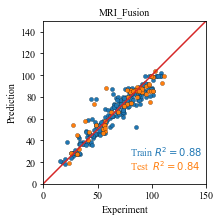

In [156]:
plt.figure(figsize=(3,3))

ax=plt.subplot(1, 1, 1)
plt.scatter(y_train, y_pred_train, c='#1f77b4', marker='o', s = 18, edgecolors='k', linewidths = 0.2)
plt.scatter(y_test, y_pred_test, c='#ff7f0e', marker='o', s = 18, edgecolors='k', linewidths = 0.2) 

plt.xlabel("Experiment",fontname="Times New Roman", fontsize=10)
plt.ylabel("Prediction",fontname="Times New Roman", fontsize=10)
x0, x1 = min(y_train), max(y_train)
length = 750
x_start, x_end = -200, 550
plt.xlim([-0, 150])
plt.ylim([-0, 150])
# ax.set_xticks([-200,-100,0,100,200,300,400,500])
# ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.yticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), '#d62728')
plt.text(80, 25, "Train $R^2={:.2f}$".format(round(r2_score(y_train, y_pred_train),2)),{'color':'#1f77b4'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.text(80, 12, "Test  $R^2 ={:.2f}$".format(r2_score(y_test, y_pred_test)),{'color':'#ff7f0e'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
#plt.text(80, 500, "Dataset_1")
plt.title('MRI_Fusion',fontname="Times New Roman", fontsize=10)
plt.savefig("Polyinfo_MRI_FusionModel.png", dpi=1200, bbox_inches='tight') 

### FFNN

In [43]:
Mix_X = []
for i in range(len(DF_MRI[Flag])):
    Mix_X.append(X.iloc[0].values * DF_MRI[Flag]['TFEA'].iloc[i] + \
                 X.iloc[1].values * DF_MRI[Flag]['HexaFOEA'].iloc[i] + \
                 X.iloc[2].values * DF_MRI[Flag]['NonaFOEA'].iloc[i] + \
                 X.iloc[3].values * DF_MRI[Flag]['PEGA'].iloc[i] + \
                 X.iloc[4].values * DF_MRI[Flag]['HEA'].iloc[i] + \
                 X.iloc[5].values * DF_MRI[Flag]['MSEA'].iloc[i])
Mix_X = np.array(Mix_X)

In [44]:
Mix_X.shape

(271, 80)

In [45]:
Mix_X

array([[1. , 0. , 0. , ..., 0. , 0.9, 0. ],
       [1. , 0.5, 0. , ..., 0. , 0.3, 0. ],
       [1. , 0. , 0. , ..., 0. , 0.3, 0. ],
       ...,
       [1. , 0. , 0. , ..., 0.6, 0.4, 0. ],
       [1. , 0. , 0. , ..., 0.6, 0.4, 0. ],
       [1. , 0. , 0. , ..., 0.7, 0.3, 0. ]])

In [55]:
x_train, x_test, y_train, y_test = train_test_split(Mix_X, DF_MRI[Flag]['19F NMR Signal-to-Noise Ratioa'].astype(np.float64), test_size=0.2, random_state=11)

In [56]:
model = keras.models.Sequential()
model.add(Dense(units = 24, input_dim = x_train.shape[1],activation='relu'))
model.add(Dense(units = 64, activation='relu'))
model.add(Dense(units = 1))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss="mean_squared_error",
              metrics=["mean_squared_error"])
model.fit(x_train, y_train, epochs = 1000, batch_size = 128,
          #callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
            validation_data = (x_test, y_test), verbose=2)

Epoch 1/1000
2/2 - 0s - loss: 5154.3354 - mean_squared_error: 5154.3354 - val_loss: 6177.7983 - val_mean_squared_error: 6177.7983
Epoch 2/1000
2/2 - 0s - loss: 5119.4375 - mean_squared_error: 5119.4370 - val_loss: 6137.3501 - val_mean_squared_error: 6137.3501
Epoch 3/1000
2/2 - 0s - loss: 5084.0776 - mean_squared_error: 5084.0776 - val_loss: 6096.4590 - val_mean_squared_error: 6096.4590
Epoch 4/1000
2/2 - 0s - loss: 5048.8867 - mean_squared_error: 5048.8867 - val_loss: 6055.6704 - val_mean_squared_error: 6055.6704
Epoch 5/1000
2/2 - 0s - loss: 5013.4790 - mean_squared_error: 5013.4790 - val_loss: 6014.9839 - val_mean_squared_error: 6014.9839
Epoch 6/1000
2/2 - 0s - loss: 4978.3481 - mean_squared_error: 4978.3481 - val_loss: 5973.9014 - val_mean_squared_error: 5973.9014
Epoch 7/1000
2/2 - 0s - loss: 4942.3101 - mean_squared_error: 4942.3096 - val_loss: 5930.8389 - val_mean_squared_error: 5930.8389
Epoch 8/1000
2/2 - 0s - loss: 4904.3901 - mean_squared_error: 4904.3901 - val_loss: 5885.3

Epoch 65/1000
2/2 - 0s - loss: 308.8488 - mean_squared_error: 308.8488 - val_loss: 242.7303 - val_mean_squared_error: 242.7303
Epoch 66/1000
2/2 - 0s - loss: 306.3605 - mean_squared_error: 306.3605 - val_loss: 245.3539 - val_mean_squared_error: 245.3539
Epoch 67/1000
2/2 - 0s - loss: 304.2728 - mean_squared_error: 304.2728 - val_loss: 248.2570 - val_mean_squared_error: 248.2570
Epoch 68/1000
2/2 - 0s - loss: 302.2631 - mean_squared_error: 302.2631 - val_loss: 251.0676 - val_mean_squared_error: 251.0676
Epoch 69/1000
2/2 - 0s - loss: 300.7758 - mean_squared_error: 300.7758 - val_loss: 253.7676 - val_mean_squared_error: 253.7676
Epoch 70/1000
2/2 - 0s - loss: 299.3373 - mean_squared_error: 299.3374 - val_loss: 256.1166 - val_mean_squared_error: 256.1166
Epoch 71/1000
2/2 - 0s - loss: 298.5015 - mean_squared_error: 298.5015 - val_loss: 258.2206 - val_mean_squared_error: 258.2206
Epoch 72/1000
2/2 - 0s - loss: 297.3347 - mean_squared_error: 297.3347 - val_loss: 259.5885 - val_mean_squared_

Epoch 130/1000
2/2 - 0s - loss: 254.2408 - mean_squared_error: 254.2408 - val_loss: 214.2613 - val_mean_squared_error: 214.2613
Epoch 131/1000
2/2 - 0s - loss: 253.6391 - mean_squared_error: 253.6391 - val_loss: 213.7373 - val_mean_squared_error: 213.7373
Epoch 132/1000
2/2 - 0s - loss: 253.1353 - mean_squared_error: 253.1353 - val_loss: 212.8111 - val_mean_squared_error: 212.8111
Epoch 133/1000
2/2 - 0s - loss: 252.5648 - mean_squared_error: 252.5648 - val_loss: 212.2447 - val_mean_squared_error: 212.2447
Epoch 134/1000
2/2 - 0s - loss: 251.9485 - mean_squared_error: 251.9485 - val_loss: 211.9215 - val_mean_squared_error: 211.9215
Epoch 135/1000
2/2 - 0s - loss: 251.3973 - mean_squared_error: 251.3973 - val_loss: 211.7252 - val_mean_squared_error: 211.7252
Epoch 136/1000
2/2 - 0s - loss: 250.8282 - mean_squared_error: 250.8282 - val_loss: 211.6620 - val_mean_squared_error: 211.6620
Epoch 137/1000
2/2 - 0s - loss: 250.3654 - mean_squared_error: 250.3654 - val_loss: 211.4792 - val_mean_

Epoch 195/1000
2/2 - 0s - loss: 227.2574 - mean_squared_error: 227.2574 - val_loss: 188.5919 - val_mean_squared_error: 188.5919
Epoch 196/1000
2/2 - 0s - loss: 226.9604 - mean_squared_error: 226.9604 - val_loss: 188.0906 - val_mean_squared_error: 188.0906
Epoch 197/1000
2/2 - 0s - loss: 226.7017 - mean_squared_error: 226.7017 - val_loss: 187.5480 - val_mean_squared_error: 187.5480
Epoch 198/1000
2/2 - 0s - loss: 226.5146 - mean_squared_error: 226.5146 - val_loss: 186.8234 - val_mean_squared_error: 186.8234
Epoch 199/1000
2/2 - 0s - loss: 226.1511 - mean_squared_error: 226.1511 - val_loss: 186.6355 - val_mean_squared_error: 186.6355
Epoch 200/1000
2/2 - 0s - loss: 225.9143 - mean_squared_error: 225.9143 - val_loss: 186.3469 - val_mean_squared_error: 186.3469
Epoch 201/1000
2/2 - 0s - loss: 225.6645 - mean_squared_error: 225.6645 - val_loss: 186.0058 - val_mean_squared_error: 186.0058
Epoch 202/1000
2/2 - 0s - loss: 225.3960 - mean_squared_error: 225.3960 - val_loss: 185.7370 - val_mean_

Epoch 260/1000
2/2 - 0s - loss: 215.3147 - mean_squared_error: 215.3147 - val_loss: 172.5539 - val_mean_squared_error: 172.5539
Epoch 261/1000
2/2 - 0s - loss: 215.1927 - mean_squared_error: 215.1927 - val_loss: 173.1576 - val_mean_squared_error: 173.1576
Epoch 262/1000
2/2 - 0s - loss: 215.0663 - mean_squared_error: 215.0663 - val_loss: 173.8565 - val_mean_squared_error: 173.8565
Epoch 263/1000
2/2 - 0s - loss: 214.9795 - mean_squared_error: 214.9795 - val_loss: 174.5598 - val_mean_squared_error: 174.5598
Epoch 264/1000
2/2 - 0s - loss: 214.8681 - mean_squared_error: 214.8681 - val_loss: 174.8933 - val_mean_squared_error: 174.8933
Epoch 265/1000
2/2 - 0s - loss: 214.8250 - mean_squared_error: 214.8250 - val_loss: 175.0531 - val_mean_squared_error: 175.0531
Epoch 266/1000
2/2 - 0s - loss: 214.8374 - mean_squared_error: 214.8374 - val_loss: 175.5970 - val_mean_squared_error: 175.5970
Epoch 267/1000
2/2 - 0s - loss: 214.5791 - mean_squared_error: 214.5791 - val_loss: 175.0543 - val_mean_

2/2 - 0s - loss: 209.3879 - mean_squared_error: 209.3879 - val_loss: 164.9290 - val_mean_squared_error: 164.9290
Epoch 325/1000
2/2 - 0s - loss: 209.2915 - mean_squared_error: 209.2915 - val_loss: 164.2103 - val_mean_squared_error: 164.2103
Epoch 326/1000
2/2 - 0s - loss: 209.2385 - mean_squared_error: 209.2385 - val_loss: 163.4819 - val_mean_squared_error: 163.4819
Epoch 327/1000
2/2 - 0s - loss: 209.1908 - mean_squared_error: 209.1908 - val_loss: 162.9152 - val_mean_squared_error: 162.9152
Epoch 328/1000
2/2 - 0s - loss: 209.1225 - mean_squared_error: 209.1225 - val_loss: 162.7640 - val_mean_squared_error: 162.7640
Epoch 329/1000
2/2 - 0s - loss: 209.0778 - mean_squared_error: 209.0778 - val_loss: 162.4822 - val_mean_squared_error: 162.4822
Epoch 330/1000
2/2 - 0s - loss: 208.9964 - mean_squared_error: 208.9964 - val_loss: 162.6164 - val_mean_squared_error: 162.6164
Epoch 331/1000
2/2 - 0s - loss: 208.9449 - mean_squared_error: 208.9449 - val_loss: 162.4944 - val_mean_squared_error: 

Epoch 389/1000
2/2 - 0s - loss: 205.6483 - mean_squared_error: 205.6483 - val_loss: 159.2614 - val_mean_squared_error: 159.2614
Epoch 390/1000
2/2 - 0s - loss: 205.6064 - mean_squared_error: 205.6064 - val_loss: 160.0108 - val_mean_squared_error: 160.0108
Epoch 391/1000
2/2 - 0s - loss: 205.6354 - mean_squared_error: 205.6354 - val_loss: 160.6770 - val_mean_squared_error: 160.6770
Epoch 392/1000
2/2 - 0s - loss: 205.5525 - mean_squared_error: 205.5525 - val_loss: 160.6014 - val_mean_squared_error: 160.6014
Epoch 393/1000
2/2 - 0s - loss: 205.5348 - mean_squared_error: 205.5348 - val_loss: 160.3215 - val_mean_squared_error: 160.3215
Epoch 394/1000
2/2 - 0s - loss: 205.4797 - mean_squared_error: 205.4797 - val_loss: 160.2378 - val_mean_squared_error: 160.2378
Epoch 395/1000
2/2 - 0s - loss: 205.4816 - mean_squared_error: 205.4816 - val_loss: 159.5907 - val_mean_squared_error: 159.5907
Epoch 396/1000
2/2 - 0s - loss: 205.3890 - mean_squared_error: 205.3890 - val_loss: 159.4736 - val_mean_

Epoch 454/1000
2/2 - 0s - loss: 203.6713 - mean_squared_error: 203.6713 - val_loss: 154.2817 - val_mean_squared_error: 154.2817
Epoch 455/1000
2/2 - 0s - loss: 203.6284 - mean_squared_error: 203.6284 - val_loss: 154.8814 - val_mean_squared_error: 154.8814
Epoch 456/1000
2/2 - 0s - loss: 203.6146 - mean_squared_error: 203.6146 - val_loss: 155.5992 - val_mean_squared_error: 155.5992
Epoch 457/1000
2/2 - 0s - loss: 203.6339 - mean_squared_error: 203.6339 - val_loss: 156.1965 - val_mean_squared_error: 156.1965
Epoch 458/1000
2/2 - 0s - loss: 203.5797 - mean_squared_error: 203.5797 - val_loss: 156.0960 - val_mean_squared_error: 156.0960
Epoch 459/1000
2/2 - 0s - loss: 203.6245 - mean_squared_error: 203.6245 - val_loss: 156.3681 - val_mean_squared_error: 156.3681
Epoch 460/1000
2/2 - 0s - loss: 203.5477 - mean_squared_error: 203.5477 - val_loss: 155.7340 - val_mean_squared_error: 155.7340
Epoch 461/1000
2/2 - 0s - loss: 203.5650 - mean_squared_error: 203.5650 - val_loss: 155.1018 - val_mean_

Epoch 519/1000
2/2 - 0s - loss: 202.7669 - mean_squared_error: 202.7669 - val_loss: 154.5193 - val_mean_squared_error: 154.5193
Epoch 520/1000
2/2 - 0s - loss: 202.7162 - mean_squared_error: 202.7162 - val_loss: 153.8450 - val_mean_squared_error: 153.8450
Epoch 521/1000
2/2 - 0s - loss: 202.7063 - mean_squared_error: 202.7063 - val_loss: 152.9219 - val_mean_squared_error: 152.9219
Epoch 522/1000
2/2 - 0s - loss: 202.7118 - mean_squared_error: 202.7118 - val_loss: 152.3969 - val_mean_squared_error: 152.3969
Epoch 523/1000
2/2 - 0s - loss: 202.6670 - mean_squared_error: 202.6670 - val_loss: 151.4478 - val_mean_squared_error: 151.4478
Epoch 524/1000
2/2 - 0s - loss: 202.6899 - mean_squared_error: 202.6899 - val_loss: 150.4148 - val_mean_squared_error: 150.4148
Epoch 525/1000
2/2 - 0s - loss: 202.7601 - mean_squared_error: 202.7601 - val_loss: 149.7619 - val_mean_squared_error: 149.7619
Epoch 526/1000
2/2 - 0s - loss: 202.7649 - mean_squared_error: 202.7649 - val_loss: 149.8141 - val_mean_

Epoch 584/1000
2/2 - 0s - loss: 202.4202 - mean_squared_error: 202.4202 - val_loss: 150.4850 - val_mean_squared_error: 150.4850
Epoch 585/1000
2/2 - 0s - loss: 202.3684 - mean_squared_error: 202.3684 - val_loss: 150.5683 - val_mean_squared_error: 150.5683
Epoch 586/1000
2/2 - 0s - loss: 202.3738 - mean_squared_error: 202.3738 - val_loss: 151.3414 - val_mean_squared_error: 151.3414
Epoch 587/1000
2/2 - 0s - loss: 202.3334 - mean_squared_error: 202.3334 - val_loss: 151.5877 - val_mean_squared_error: 151.5877
Epoch 588/1000
2/2 - 0s - loss: 202.3299 - mean_squared_error: 202.3299 - val_loss: 151.9113 - val_mean_squared_error: 151.9113
Epoch 589/1000
2/2 - 0s - loss: 202.3775 - mean_squared_error: 202.3775 - val_loss: 152.2623 - val_mean_squared_error: 152.2623
Epoch 590/1000
2/2 - 0s - loss: 202.3236 - mean_squared_error: 202.3236 - val_loss: 153.3900 - val_mean_squared_error: 153.3900
Epoch 591/1000
2/2 - 0s - loss: 202.3425 - mean_squared_error: 202.3425 - val_loss: 154.0872 - val_mean_

Epoch 649/1000
2/2 - 0s - loss: 202.3757 - mean_squared_error: 202.3757 - val_loss: 152.6829 - val_mean_squared_error: 152.6829
Epoch 650/1000
2/2 - 0s - loss: 202.1483 - mean_squared_error: 202.1483 - val_loss: 150.8261 - val_mean_squared_error: 150.8261
Epoch 651/1000
2/2 - 0s - loss: 202.2831 - mean_squared_error: 202.2831 - val_loss: 148.6378 - val_mean_squared_error: 148.6378
Epoch 652/1000
2/2 - 0s - loss: 202.2276 - mean_squared_error: 202.2276 - val_loss: 147.9194 - val_mean_squared_error: 147.9194
Epoch 653/1000
2/2 - 0s - loss: 202.2939 - mean_squared_error: 202.2939 - val_loss: 146.9455 - val_mean_squared_error: 146.9455
Epoch 654/1000
2/2 - 0s - loss: 202.3076 - mean_squared_error: 202.3076 - val_loss: 147.0509 - val_mean_squared_error: 147.0509
Epoch 655/1000
2/2 - 0s - loss: 202.4061 - mean_squared_error: 202.4061 - val_loss: 147.3444 - val_mean_squared_error: 147.3444
Epoch 656/1000
2/2 - 0s - loss: 202.2100 - mean_squared_error: 202.2100 - val_loss: 149.0494 - val_mean_

Epoch 714/1000
2/2 - 0s - loss: 202.2182 - mean_squared_error: 202.2182 - val_loss: 151.4331 - val_mean_squared_error: 151.4331
Epoch 715/1000
2/2 - 0s - loss: 202.1162 - mean_squared_error: 202.1162 - val_loss: 150.5027 - val_mean_squared_error: 150.5027
Epoch 716/1000
2/2 - 0s - loss: 202.0959 - mean_squared_error: 202.0959 - val_loss: 150.1827 - val_mean_squared_error: 150.1827
Epoch 717/1000
2/2 - 0s - loss: 202.1114 - mean_squared_error: 202.1114 - val_loss: 149.6580 - val_mean_squared_error: 149.6580
Epoch 718/1000
2/2 - 0s - loss: 202.1313 - mean_squared_error: 202.1313 - val_loss: 149.2947 - val_mean_squared_error: 149.2947
Epoch 719/1000
2/2 - 0s - loss: 202.1481 - mean_squared_error: 202.1481 - val_loss: 149.8213 - val_mean_squared_error: 149.8213
Epoch 720/1000
2/2 - 0s - loss: 202.0992 - mean_squared_error: 202.0992 - val_loss: 149.8212 - val_mean_squared_error: 149.8212
Epoch 721/1000
2/2 - 0s - loss: 202.1063 - mean_squared_error: 202.1063 - val_loss: 149.8695 - val_mean_

Epoch 779/1000
2/2 - 0s - loss: 202.0821 - mean_squared_error: 202.0821 - val_loss: 149.7916 - val_mean_squared_error: 149.7916
Epoch 780/1000
2/2 - 0s - loss: 202.0459 - mean_squared_error: 202.0459 - val_loss: 150.7668 - val_mean_squared_error: 150.7668
Epoch 781/1000
2/2 - 0s - loss: 202.0974 - mean_squared_error: 202.0974 - val_loss: 152.0176 - val_mean_squared_error: 152.0176
Epoch 782/1000
2/2 - 0s - loss: 202.0777 - mean_squared_error: 202.0777 - val_loss: 152.4106 - val_mean_squared_error: 152.4106
Epoch 783/1000
2/2 - 0s - loss: 202.1187 - mean_squared_error: 202.1187 - val_loss: 153.2016 - val_mean_squared_error: 153.2016
Epoch 784/1000
2/2 - 0s - loss: 202.0992 - mean_squared_error: 202.0992 - val_loss: 152.9524 - val_mean_squared_error: 152.9524
Epoch 785/1000
2/2 - 0s - loss: 202.0895 - mean_squared_error: 202.0895 - val_loss: 152.4293 - val_mean_squared_error: 152.4293
Epoch 786/1000
2/2 - 0s - loss: 202.0691 - mean_squared_error: 202.0691 - val_loss: 151.8281 - val_mean_

2/2 - 0s - loss: 202.1305 - mean_squared_error: 202.1305 - val_loss: 151.4205 - val_mean_squared_error: 151.4205
Epoch 844/1000
2/2 - 0s - loss: 202.0331 - mean_squared_error: 202.0331 - val_loss: 151.6791 - val_mean_squared_error: 151.6791
Epoch 845/1000
2/2 - 0s - loss: 202.1452 - mean_squared_error: 202.1452 - val_loss: 152.1444 - val_mean_squared_error: 152.1444
Epoch 846/1000
2/2 - 0s - loss: 202.0408 - mean_squared_error: 202.0408 - val_loss: 151.3609 - val_mean_squared_error: 151.3609
Epoch 847/1000
2/2 - 0s - loss: 202.1246 - mean_squared_error: 202.1246 - val_loss: 150.8304 - val_mean_squared_error: 150.8304
Epoch 848/1000
2/2 - 0s - loss: 202.0311 - mean_squared_error: 202.0311 - val_loss: 149.1583 - val_mean_squared_error: 149.1583
Epoch 849/1000
2/2 - 0s - loss: 202.1241 - mean_squared_error: 202.1241 - val_loss: 147.9930 - val_mean_squared_error: 147.9930
Epoch 850/1000
2/2 - 0s - loss: 202.1329 - mean_squared_error: 202.1329 - val_loss: 147.9068 - val_mean_squared_error: 

Epoch 908/1000
2/2 - 0s - loss: 202.0057 - mean_squared_error: 202.0057 - val_loss: 148.7032 - val_mean_squared_error: 148.7032
Epoch 909/1000
2/2 - 0s - loss: 202.0912 - mean_squared_error: 202.0912 - val_loss: 146.9366 - val_mean_squared_error: 146.9366
Epoch 910/1000
2/2 - 0s - loss: 202.1064 - mean_squared_error: 202.1064 - val_loss: 146.5618 - val_mean_squared_error: 146.5618
Epoch 911/1000
2/2 - 0s - loss: 202.1623 - mean_squared_error: 202.1623 - val_loss: 146.8766 - val_mean_squared_error: 146.8766
Epoch 912/1000
2/2 - 0s - loss: 202.0997 - mean_squared_error: 202.0997 - val_loss: 147.1502 - val_mean_squared_error: 147.1502
Epoch 913/1000
2/2 - 0s - loss: 202.1160 - mean_squared_error: 202.1160 - val_loss: 148.3085 - val_mean_squared_error: 148.3085
Epoch 914/1000
2/2 - 0s - loss: 202.0315 - mean_squared_error: 202.0315 - val_loss: 149.0937 - val_mean_squared_error: 149.0937
Epoch 915/1000
2/2 - 0s - loss: 201.9965 - mean_squared_error: 201.9965 - val_loss: 150.3944 - val_mean_

Epoch 973/1000
2/2 - 0s - loss: 202.0103 - mean_squared_error: 202.0103 - val_loss: 148.0794 - val_mean_squared_error: 148.0794
Epoch 974/1000
2/2 - 0s - loss: 202.1069 - mean_squared_error: 202.1069 - val_loss: 147.5224 - val_mean_squared_error: 147.5224
Epoch 975/1000
2/2 - 0s - loss: 202.0834 - mean_squared_error: 202.0834 - val_loss: 148.3918 - val_mean_squared_error: 148.3918
Epoch 976/1000
2/2 - 0s - loss: 202.0461 - mean_squared_error: 202.0461 - val_loss: 149.2959 - val_mean_squared_error: 149.2959
Epoch 977/1000
2/2 - 0s - loss: 202.0103 - mean_squared_error: 202.0103 - val_loss: 149.9957 - val_mean_squared_error: 149.9957
Epoch 978/1000
2/2 - 0s - loss: 201.9960 - mean_squared_error: 201.9960 - val_loss: 150.4335 - val_mean_squared_error: 150.4335
Epoch 979/1000
2/2 - 0s - loss: 201.9916 - mean_squared_error: 201.9916 - val_loss: 150.6071 - val_mean_squared_error: 150.6071
Epoch 980/1000
2/2 - 0s - loss: 202.1328 - mean_squared_error: 202.1328 - val_loss: 150.0532 - val_mean_

In [57]:
filepath = 'MRI_DNN.model'
save_model(model, filepath, save_format='h5')

In [58]:
model = load_model('MRI_DNN.model')

In [59]:
y_pred_train = model.predict((x_train))
print("Train set R^2: %.2f" % r2_score(y_train, y_pred_train))
print("Train MAE score: %.2f" % mean_absolute_error(y_train, y_pred_train))
print("Train RMSE score: %.2f" % np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred_test = model.predict((x_test))
print("Test set R^2: %.2f" % r2_score(y_test, y_pred_test))
print("Test MAE score: %.2f" % mean_absolute_error(y_test, y_pred_test))
print("Test RMSE score: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))

Train set R^2: 0.61
Train MAE score: 10.95
Train RMSE score: 14.21
Test set R^2: 0.71
Test MAE score: 10.37
Test RMSE score: 12.13


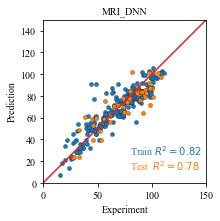

In [172]:
plt.figure(figsize=(3,3))

ax=plt.subplot(1, 1, 1)
plt.scatter(y_train, y_pred_train, c='#1f77b4', marker='o', s = 18, edgecolors='k', linewidths = 0.2)
plt.scatter(y_test, y_pred_test, c='#ff7f0e', marker='o', s = 18, edgecolors='k', linewidths = 0.2) 

plt.xlabel("Experiment",fontname="Times New Roman", fontsize=10)
plt.ylabel("Prediction",fontname="Times New Roman", fontsize=10)
x0, x1 = min(y_train), max(y_train)
length = 750
x_start, x_end = -200, 550
plt.xlim([-0, 150])
plt.ylim([-0, 150])
# ax.set_xticks([-200,-100,0,100,200,300,400,500])
# ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.yticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), '#d62728')
plt.text(80, 25, "Train $R^2={:.2f}$".format(round(r2_score(y_train, y_pred_train),2)),{'color':'#1f77b4'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.text(80, 12, "Test  $R^2 ={:.2f}$".format(r2_score(y_test, y_pred_test)),{'color':'#ff7f0e'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
#plt.text(80, 500, "Dataset_1")
plt.title('MRI_DNN',fontname="Times New Roman", fontsize=10)
plt.savefig("Polyinfo_MRI_DNN.png", dpi=1200, bbox_inches='tight') 

### RNN

In [46]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, LSTM, Embedding, Bidirectional, TimeDistributed, Reshape
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import mean_absolute_error, r2_score


def getRNNmodel(LSTMunits):#, out_dim, input_dim):

    RNNmodel = Sequential()
    #RNNmodel.add(Embedding(input_dim, out_dim, input_length=input_len))
    RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True), input_shape=(100, 80)))
    #RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True)))
    RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True)))
    RNNmodel.add(TimeDistributed(Dense(int(LSTMunits/2), activation="relu")))
    RNNmodel.add(Reshape((int(LSTMunits/2*100),)))
    RNNmodel.add(Dense(1))

    return RNNmodel

In [47]:
Mix_X_100Block = []
for i in range(len(DF_MRI[Flag])):
        random.seed(10)

        Random_position = []
        Random_position_all = []

        Rest = range(0, 100)
        for col in ['TFEA', 'HexaFOEA', 'NonaFOEA', 'PEGA', 'HEA', 'MSEA']:

            X_random_position = random.sample(Rest, int(DF_MRI[Flag][col].iloc[i] * 100))
            Random_position.append(X_random_position)
            for p in X_random_position:
                Random_position_all.append(p)
            Rest = []
            for x in range(0, 100):
                if x not in Random_position_all:
                    Rest.append(x)
        
        Sequency_X = [0 for a in range(100)]
        for j in range(100):
            if j in Random_position[0]:
                Sequency_X[j] = list(X.iloc[0].values)
            elif j in Random_position[1]:
                Sequency_X[j] = list(X.iloc[1].values)
            elif j in Random_position[2]:
                Sequency_X[j] = list(X.iloc[2].values)
            elif j in Random_position[3]:
                Sequency_X[j] = list(X.iloc[3].values)
            elif j in Random_position[4]:
                Sequency_X[j] = list(X.iloc[4].values)
            elif j in Random_position[5]:
                Sequency_X[j] = list(X.iloc[5].values)
                
        Mix_X_100Block.append(Sequency_X)   

Mix_X_100Block = np.array(Mix_X_100Block)

In [48]:
Mix_X_100Block.shape

(271, 100, 80)

In [49]:
Mix_X_100Block

array([[[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       [[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       [[1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 0]],

       ...,

       [[1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0]],

       [[1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        ...,
        [1, 0, 0, ..., 

In [63]:
X_train, X_test, y_train, y_test = train_test_split(Mix_X_100Block, DF_MRI[Flag]['19F NMR Signal-to-Noise Ratioa'].astype(np.float64), test_size=0.2, random_state=11)

LSTMunits = 20
RNNmodel = getRNNmodel(LSTMunits)
RNNmodel.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)

history = RNNmodel.fit(X_train, y_train, validation_split=0.2, epochs=200, \
                        batch_size=64)#, callbacks=[es])

Epoch 1/200
3/3 [==============================] - 1s 359ms/step - loss: 5287.2393 - mean_squared_error: 5287.2393 - val_loss: 4428.7246 - val_mean_squared_error: 4428.7246
Epoch 2/200
3/3 [==============================] - 0s 52ms/step - loss: 5176.4541 - mean_squared_error: 5176.4541 - val_loss: 4297.5142 - val_mean_squared_error: 4297.5142
Epoch 3/200
3/3 [==============================] - 0s 43ms/step - loss: 5005.6357 - mean_squared_error: 5005.6357 - val_loss: 4087.4382 - val_mean_squared_error: 4087.4382
Epoch 4/200
3/3 [==============================] - 0s 28ms/step - loss: 4743.4683 - mean_squared_error: 4743.4683 - val_loss: 3797.1624 - val_mean_squared_error: 3797.1624
Epoch 5/200
3/3 [==============================] - 0s 26ms/step - loss: 4393.9395 - mean_squared_error: 4393.9395 - val_loss: 3417.9438 - val_mean_squared_error: 3417.9438
Epoch 6/200
3/3 [==============================] - 0s 20ms/step - loss: 3933.0298 - mean_squared_error: 3933.0298 - val_loss: 2958.3896 - v

Epoch 98/200
3/3 [==============================] - 0s 17ms/step - loss: 84.5485 - mean_squared_error: 84.5485 - val_loss: 95.8484 - val_mean_squared_error: 95.8484
Epoch 99/200
3/3 [==============================] - 0s 17ms/step - loss: 81.9567 - mean_squared_error: 81.9567 - val_loss: 105.9781 - val_mean_squared_error: 105.9781
Epoch 100/200
3/3 [==============================] - 0s 21ms/step - loss: 80.5488 - mean_squared_error: 80.5488 - val_loss: 109.7719 - val_mean_squared_error: 109.7719
Epoch 101/200
3/3 [==============================] - 0s 17ms/step - loss: 80.4846 - mean_squared_error: 80.4846 - val_loss: 101.6504 - val_mean_squared_error: 101.6504
Epoch 102/200
3/3 [==============================] - 0s 19ms/step - loss: 78.7833 - mean_squared_error: 78.7833 - val_loss: 101.9704 - val_mean_squared_error: 101.9704
Epoch 103/200
3/3 [==============================] - 0s 21ms/step - loss: 78.0648 - mean_squared_error: 78.0648 - val_loss: 97.3719 - val_mean_squared_error: 97.371

3/3 [==============================] - 0s 18ms/step - loss: 49.5746 - mean_squared_error: 49.5746 - val_loss: 96.5804 - val_mean_squared_error: 96.5804
Epoch 197/200
3/3 [==============================] - 0s 17ms/step - loss: 45.4365 - mean_squared_error: 45.4365 - val_loss: 91.3123 - val_mean_squared_error: 91.3123
Epoch 198/200
3/3 [==============================] - 0s 19ms/step - loss: 43.3083 - mean_squared_error: 43.3083 - val_loss: 84.4826 - val_mean_squared_error: 84.4826
Epoch 199/200
3/3 [==============================] - 0s 20ms/step - loss: 44.1612 - mean_squared_error: 44.1612 - val_loss: 84.4165 - val_mean_squared_error: 84.4165
Epoch 200/200
3/3 [==============================] - 0s 17ms/step - loss: 42.8947 - mean_squared_error: 42.8947 - val_loss: 80.8345 - val_mean_squared_error: 80.8345


In [209]:
filepath = 'MRI_RNN.model'
save_model(RNNmodel, filepath, save_format='h5')

In [64]:
RNNmodel = load_model('MRI_RNN.model')

In [65]:
X_train, X_test, y_train, y_test = train_test_split(Mix_X_100Block, DF_MRI[Flag]['19F NMR Signal-to-Noise Ratioa'].astype(np.float64), test_size=0.2, random_state=11)


In [66]:
X_train.shape

(216, 100, 80)

In [67]:
y_pred_train = RNNmodel.predict((X_train))
print("Train set R^2: %.2f" % r2_score(y_train, y_pred_train))
print("Train MAE score: %.2f" % mean_absolute_error(y_train, y_pred_train))
print("Train RMSE score: %.2f" % np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred_test = RNNmodel.predict((X_test))
print("Test set R^2: %.2f" % r2_score(y_test, y_pred_test))
print("Test MAE score: %.2f" % mean_absolute_error(y_test, y_pred_test))
print("Test RMSE score: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))

Train set R^2: 0.92
Train MAE score: 4.15
Train RMSE score: 6.37
Test set R^2: 0.84
Test MAE score: 7.34
Test RMSE score: 9.11


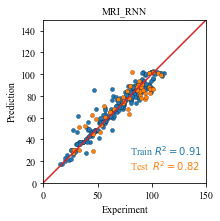

In [142]:
plt.figure(figsize=(3,3))

ax=plt.subplot(1, 1, 1)
plt.scatter(y_train, y_pred_train, c='#1f77b4', marker='o', s = 18, edgecolors='k', linewidths = 0.2)
plt.scatter(y_test, y_pred_test, c='#ff7f0e', marker='o', s = 18, edgecolors='k', linewidths = 0.2) 

plt.xlabel("Experiment",fontname="Times New Roman", fontsize=10)
plt.ylabel("Prediction",fontname="Times New Roman", fontsize=10)
x0, x1 = min(y_train), max(y_train)
length = 750
x_start, x_end = -200, 550
plt.xlim([-0, 150])
plt.ylim([-0, 150])
# ax.set_xticks([-200,-100,0,100,200,300,400,500])
# ax.set_yticks([-200,-100,0,100,200,300,400,500])
plt.xticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.yticks(fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.gca().set_aspect("equal", adjustable="box")
# the unit line
plt.plot(np.arange(x_start, x_end, 0.01*length),
np.arange(x_start, x_end, 0.01*length), '#d62728')
plt.text(80, 25, "Train $R^2={:.2f}$".format(round(r2_score(y_train, y_pred_train),2)),{'color':'#1f77b4'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
plt.text(80, 12, "Test  $R^2 ={:.2f}$".format(r2_score(y_test, y_pred_test)),{'color':'#ff7f0e'}, fontname="Times New Roman", fontsize=10, fontweight='normal')
#plt.text(80, 500, "Dataset_1")
plt.title('MRI_RNN',fontname="Times New Roman", fontsize=10)
plt.savefig("Polyinfo_MRI_RNN.png", dpi=1200, bbox_inches='tight') 